In [1]:
import yfinance as yf
import pandas as pd
from pandas.tseries.frequencies import to_offset
pd.set_option('display.max_rows', 300)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import numpy as np
from numpy.polynomial.polynomial import polyfit
%matplotlib notebook

TICKER = "QQQ"

In [2]:
ticker = yf.Ticker(TICKER).history(period="max", interval="1d")
ticker['Turnover'] = (ticker.Open + ticker.High + ticker.Low + ticker.Close)/4 * ticker.Volume / 1000000
ticker = ticker.loc[:, ["Open", "High", "Low", "Close", "Volume", "Turnover"]]
ticker

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
1999-03-10,44.229291,44.256326,43.499345,44.175220,5232000,230.417518
1999-03-11,44.499635,44.756467,43.526374,44.391495,9688600,429.141935
1999-03-12,44.229283,44.256318,42.958638,43.310093,8743600,381.995495
1999-03-15,43.634528,44.607789,43.174932,44.553719,6369000,280.189773
1999-03-16,44.742949,45.121439,44.256318,44.932194,4905800,219.599429
...,...,...,...,...,...,...
2022-05-16,300.149994,302.260010,297.130005,298.440002,59190400,17727.229011
2022-05-17,304.450012,306.559998,300.549988,306.170013,62715300,19092.575740
2022-05-18,301.540009,302.250000,289.850006,291.140015,79477100,23540.720217


In [3]:
logic = {'Open'    : 'first',
         'High'    : 'max',
         'Low'     : 'min',
         'Close'   : 'last',
         'Volume'  : 'sum',
         'Turnover': 'sum'}
ticker = ticker.resample("W").apply(logic)
ticker.index = ticker.index + to_offset("-2d")
ticker['Return'] = 100*ticker['Close'].pct_change()
ticker['zVolume'] = (ticker.Volume - ticker.Volume.rolling(52).mean())/ticker.Volume.rolling(52).std()
ticker.dropna(inplace=True)
ticker

,Open,High,Low,Close,Volume,Turnover,Return,zVolume
Date,,,,,,,,
2000-03-03,89.323709,96.136506,86.944627,96.082436,151419600,13938.892383,6.726741,1.938715
2000-03-10,96.677229,100.732476,91.946106,99.056305,166104000,16099.811136,3.095123,2.196173
2000-03-17,95.163264,98.731887,87.377186,95.866150,214558200,20004.692402,-3.220547,3.089888
2000-03-24,96.028354,104.247034,89.594063,101.705742,120262900,11693.794356,6.091401,0.801096
2000-03-31,102.084215,103.381896,89.539992,94.730682,130957000,12560.959207,-6.858078,1.021054
...,...,...,...,...,...,...,...,...
2022-04-22,337.350006,347.869995,324.959991,325.399994,338939400,114695.687049,-3.850131,0.739874
2022-04-29,323.730011,329.899994,312.600006,313.250000,510086400,164251.123781,-3.733864,2.146917
2022-05-06,312.829987,330.290009,305.109985,309.250000,603840600,191264.388208,-1.276935,2.687755


In [4]:
mindate = str(ticker.index.min())[:10]
ticker.zVolume.mean()

0.08815009554873435

<IPython.core.display.Javascript object>


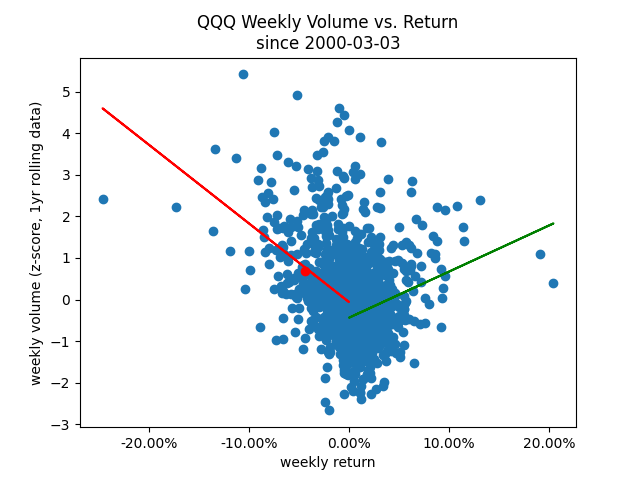

In [5]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel("weekly volume (z-score, 1yr rolling data)")
ax1.set_xlabel("weekly return")
titlestr = TICKER + " Weekly Volume vs. Return\n" + \
        f"since {mindate}"
ax1.set_title(titlestr)
ax1.scatter(ticker['Return'], ticker.zVolume)
ax1.scatter(ticker.loc["2022-05-20",["Return"]], ticker.loc["2022-05-20",["zVolume"]], color="red")

# # Fit linear regression via least squares with numpy.polyfit
# # It returns an slope (b) and intercept (a)
# # deg=1 means linear fit (i.e. polynomial of degree 1)
b1, m1 = np.polyfit(ticker[ticker['Return'] < 0]['Return'], ticker[ticker['Return'] < 0]['zVolume'], deg=1)
b2, m2 = np.polyfit(ticker[ticker['Return'] >= 0]['Return'], ticker[ticker['Return'] >= 0]['zVolume'], deg=1)


# # Plot regression line
ax1.plot(ticker[ticker['Return'] < 0]['Return'], m1 + b1 * ticker[ticker['Return'] < 0]['Return'], '-', color="red");
ax1.plot(ticker[ticker['Return'] >= 0]['Return'], m2 + b2 * ticker[ticker['Return'] >= 0]['Return'], '-', color="green");

fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax1.xaxis.set_major_formatter(xticks)
plt.show()

In [6]:
ticker[(ticker['Return'] < -4.5) & (ticker['zVolume'] < .25)]

,Open,High,Low,Close,Volume,Turnover,Return,zVolume
Date,,,,,,,,
2000-09-08,87.917918,88.026059,81.983668,82.294571,77458100,6559.345427,-7.308178,-0.968884
2001-07-06,39.492754,40.210802,35.893857,36.032276,173487300,6638.393403,-8.862144,-0.668784
2001-08-10,36.793569,37.070407,33.938663,34.847038,280911700,9990.941743,-6.716134,0.153522
2001-08-17,35.115236,36.075524,32.623695,32.666950,283505200,9738.067589,-6.256165,0.144118
2002-08-30,21.887553,22.069226,19.915075,20.321682,447741200,9365.450797,-6.600422,0.201692
2002-09-20,19.776664,20.079453,18.582789,18.747162,404716200,7757.192282,-5.741614,-0.204195
2002-10-04,18.228082,19.024002,17.397579,17.605207,444620100,8102.931067,-4.504882,0.151706
2002-12-13,22.683463,23.090069,21.636663,21.662617,344615300,7649.309281,-5.402347,-0.768471
2003-01-17,23.643739,23.764856,21.861598,21.896202,321024800,7390.367652,-6.605155,-0.952471


In [33]:
ticker['lambda'] = ticker.apply(lambda x: x.name,axis=1)
ticker

,Open,High,Low,Close,Volume,Turnover,Return,zVolume,lambda
Date,,,,,,,,,
2000-03-03,89.323709,96.136506,86.944627,96.082436,151419600,13938.892383,6.726741,1.938715,2000-03-03
2000-03-10,96.677229,100.732476,91.946106,99.056305,166104000,16099.811136,3.095123,2.196173,2000-03-10
2000-03-17,95.163264,98.731887,87.377186,95.866150,214558200,20004.692402,-3.220547,3.089888,2000-03-17
2000-03-24,96.028354,104.247034,89.594063,101.705742,120262900,11693.794356,6.091401,0.801096,2000-03-24
2000-03-31,102.084215,103.381896,89.539992,94.730682,130957000,12560.959207,-6.858078,1.021054,2000-03-31
...,...,...,...,...,...,...,...,...,...
2022-04-22,337.350006,347.869995,324.959991,325.399994,338939400,114695.687049,-3.850131,0.739874,2022-04-22
2022-04-29,323.730011,329.899994,312.600006,313.250000,510086400,164251.123781,-3.733864,2.146917,2022-04-29
2022-05-06,312.829987,330.290009,305.109985,309.250000,603840600,191264.388208,-1.276935,2.687755,2022-05-06
